# Intoduction to MMIs
This notebook is largely based on [1].
It leverages meow to do EME calculations.

## Multimode waveguides:
A waveguide of apropriate size can support (guide) more than one mode (per polarization*) these are called multimode waveguides (**we will only consider TE polarization in the following**):

![Multimode.PNG](../assets/Multimode.PNG)
*Modes of a 2D waveguide (from [1])*

The set of supported (guided) eigenmodes represents an orthogonal basis to express arbitrary (guided) fields inside such multimode waveguides. As the propagation constants of different eigenmodes are usually distinct** the phase relation between the different modes will vary along the direction of propagation leading to spatial interference patterns.
The different propagation constants show an almost quadratic dependence on the mode number ([1] eq. 4.4):
$$ \beta_v \approx k_0 n_r -\frac{(v+1)^2\pi\lambda_0}{4n_cW_e^2}$$
where $v$ is the mode number, $\lambda_0$ is the vacuum wavelength and $n_c$ the refractive index of the core material.
The effective width $W_e$ is the width of the mode taking into account the penetration depth of the evanescent field. It is assumed to be independent of $v$.

This relation leads to a propagation constant difference (compared to the fundamental mode) of ([1] eq. 4.6 typo corrected):
$$ \beta_0 - \beta_v = \frac{v(v+2)\pi}{3L_\pi}$$
where $L_pi$ is the beat length of modes 0 and 1.

Thus at position $z$ along the waveguide the modes will have aquired a relative phase factor of:
$$P = e^{i\frac{v(v+2)\pi}{3L_\pi}z}$$

Note that the relative phase factor of the fundamental mode is $1$ everywhere per definition.

From these phase factors we deduce special locations along the waveguide, where specific interference phenomena occurr. 
E.g. if all phase factors are equal (i.e. $1$) the same field distribution as at $z=0$ will occurr. Switching the sign of the odd modes the original field distribution will be mirrored to the other side of the waveguide ($P=(-1)^v$).

It can be easily found [1] that these interferences occurr at $z=p(3L_\pi)$ with $p$ an even integer for an unchanged image and $p$ an odd integer for a mirrored image.

Inspecting the points inbetween mentioned positions one findes that the original and mirrored field distributions are superimposed in quadrature (see [1] eq. 4.20) which is the behavior we are looking for in this notebook.
Note that other techniques can be used to selectively excite modes to create the interference pattern at smaller $z$ leading to smaller footprint devices. This technique is considered out of the scope of the current task, as only an optimization of the power transmission has been requested.

*see discussion in the [single mode notebook](10_singlemode)

**except for degenerate modes e.g. caused by symmetry

[1] Sosa Andrade, Andrés: "Design of a silicon photonic multimode interference coupler." (2012)

In [1]:
#| hide
import meow as mw
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] ="auto"
from skill_challenge.util import cachedComputeModes

Lets create our multimode waveguide:

In [6]:
env = mw.Environment(
    wl=1.55,
    T=27,
)

def create_multimode(L=1e3, w=2.3, t_core=0.4):
    slab_ox = mw.Structure(
        material=mw.silicon_oxide,
        geometry=mw.Box(
            x_min=-10,
            x_max=10,
            y_min=-2.0,
            y_max=2.0,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    core = mw.Structure(
        material=mw.silicon_nitride,
        geometry=mw.Box(
            x_min=-w / 2,
            x_max=w / 2,
            y_min=0.0,
            y_max=t_core,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    return [slab_ox, core]

def create_io(L=1e3, w=1, t_core=0.4, offset=1):
    slab_ox = mw.Structure(
        material=mw.silicon_oxide,
        geometry=mw.Box(
            x_min=-10,
            x_max=10,
            y_min=-2.0,
            y_max=2.0,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    core1 = mw.Structure(
        material=mw.silicon_nitride,
        geometry=mw.Box(
            x_min=-w / 2 + offset,
            x_max=w / 2  + offset,
            y_min=0.0,
            y_max=t_core,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )
    
    core2 = mw.Structure(
        material=mw.silicon_nitride,
        geometry=mw.Box(
            x_min=-w / 2 - offset,
            x_max=w / 2  - offset,
            y_min=0.0,
            y_max=t_core,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )
    return [slab_ox, core1, core2]

In [20]:
io_width = 0.9
w_tot = 4
def construct_css(L):
    mesh = mw.Mesh2d(  # decrease approx_dy for more accuracy
                x=np.linspace(-w_tot/2-1,w_tot/2+1,100),
                y=np.linspace(-1.5,1.5,100)
            )
    c_mmi = mw.Cell(
            structures=create_multimode(w=w_tot),
            mesh=mesh,
            z_min=0,
            z_max=L,
        )
    c_launch = mw.Cell(
            structures=create_io(w=io_width, offset=w_tot/2-io_width/4*3),
            mesh=mesh,
            z_min=0,
            z_max=0,
        )
    
    c_receive = mw.Cell(
            structures=create_io(w=io_width, offset=w_tot/6-io_width/4*3),
            mesh=mesh,
            z_min=L,
            z_max=L,
        )

    css = [mw.CrossSection(
        cell=cell,
        env=env,
    ) for cell in [c_launch, c_mmi]]
    
    return css

In [21]:
css = construct_css(1e3)

/opt/conda/lib/python3.9/site-packages/matplotlib/text.py:825: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/conda/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/conda/lib/python3.9/site-packages/matplotlib/text.py:685: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(textobj.convert_yunits(textobj._y))


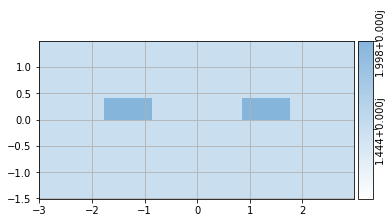

In [22]:
mw.vis(css[0])

In [23]:
modes = [cachedComputeModes(cs, num_modes=10) for cs in css]
te_modes = [m for m in modes[1] if np.real(m.te_fraction)>0.5]

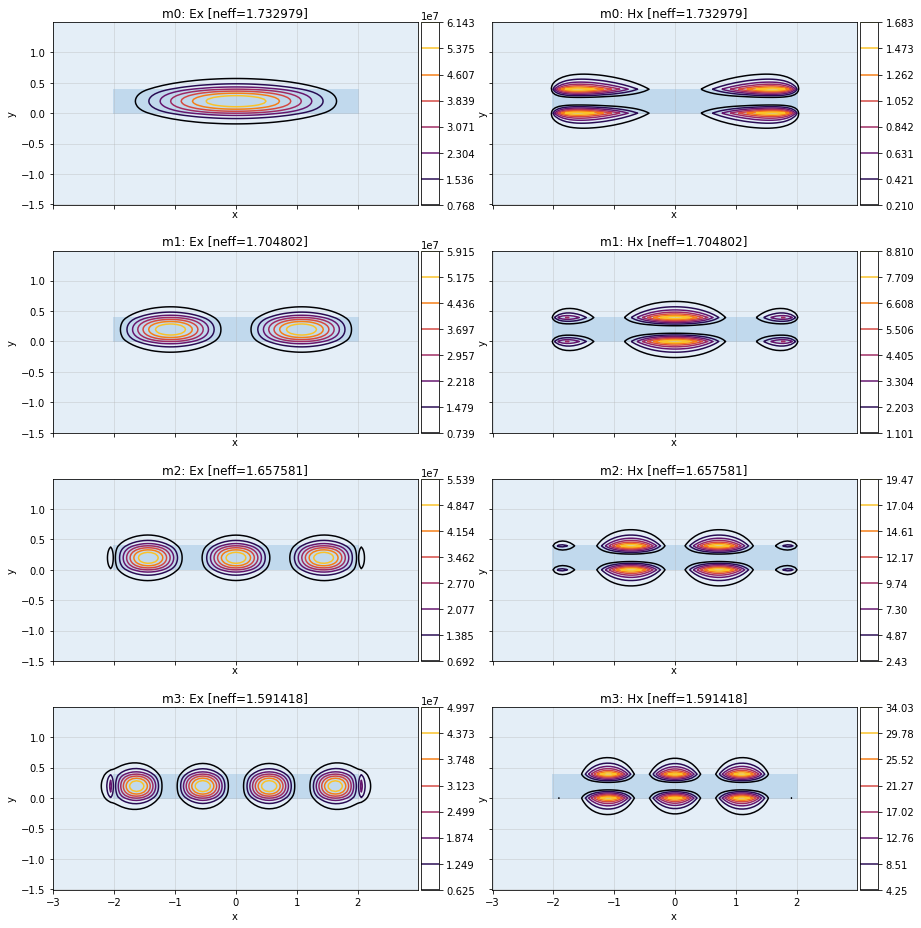

In [24]:
mw.vis(te_modes[:4])

In [25]:
k0 = 2*np.pi/env.wl
l_pi = np.pi/(k0*te_modes[0].neff-k0*te_modes[1].neff)
l_pi = np.real(l_pi)

In [26]:
l_pi*3/2

4.126e+01

In [27]:
from meow.eme.propagate import propagate_modes
ex_l = np.zeros(10)
ex_r = np.zeros(10)
ex_l[0] = 1
ex_l[1] = 1

L = l_pi*3
z = np.linspace(0,L,1000)
y = 0.2

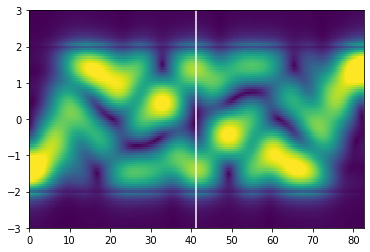

In [28]:
E, x = propagate_modes(modes, ex_l, ex_r, y, z)
X, Y = np.meshgrid(z, x)
lim = np.quantile(np.abs(E), 0.98)
plt.pcolormesh(X, Y, np.abs(E).T, shading="nearest", vmin=0, vmax=lim)
plt.axvline(L/2, color="w")

As we can see the 2 images exist as hoped for.
Note: It would be great to calculate the s-parameters now, however that requires ports in meow to work properly

# Note to calculate the s-parameters we will have to introduce ports to meow

{'left@0': 0, 'left@1': 1, 'left@2': 2, 'left@3': 3, 'left@4': 4, 'left@5': 5, 'left@6': 6, 'left@7': 7, 'left@8': 8, 'left@9': 9, 'left@10': 10, 'left@11': 11, 'right@0': 12, 'right@1': 13, 'right@2': 14, 'right@3': 15, 'right@4': 16, 'right@5': 17, 'right@6': 18, 'right@7': 19, 'right@8': 20, 'right@9': 21, 'right@10': 22, 'right@11': 23}


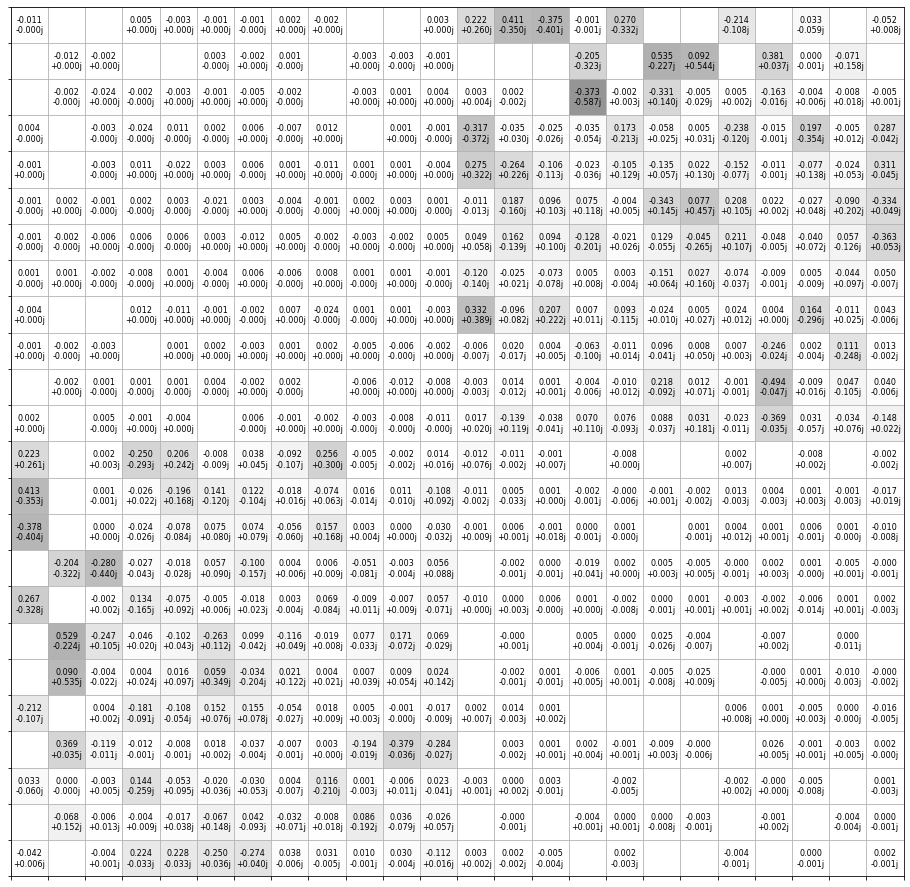

In [ ]:
css = construct_css(l_pi*3/2)
modes = [cachedComputeModes(cs, num_modes=12) for cs in css]
S, port_map = mw.compute_s_matrix(modes)
print(port_map)
mw.visualize(S)